In [ ]:
!pip install scikit-image
!pip install seaborn
!pip install opencv-python

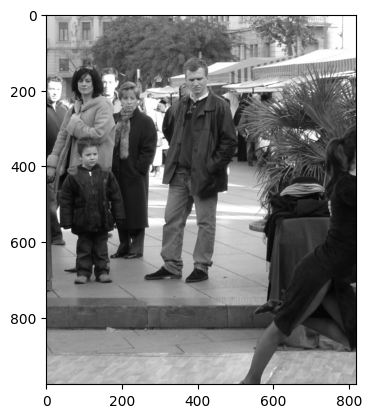

In [8]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
from skimage.feature import hog
import glob

# Data:
# https://github.com/vinay0410/Pedestrian_Detection

# Replace vehicle and non-vehicle data sources with the INRIA Person Dataset
pedestrian = glob.glob("INRIAPerson/Train/pos/*.png")
non_pedestrian = glob.glob("INRIAPerson/Train/neg/*.png")

img_color = cv2.imread(pedestrian[0])
plt.imshow(img_color)
img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

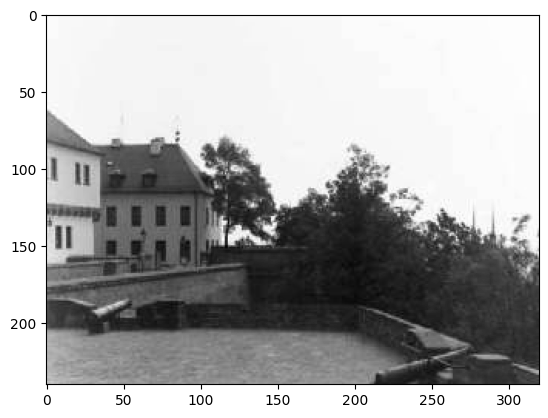

In [9]:
img_color = cv2.imread(non_pedestrian[0])
plt.imshow(img_color)
img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

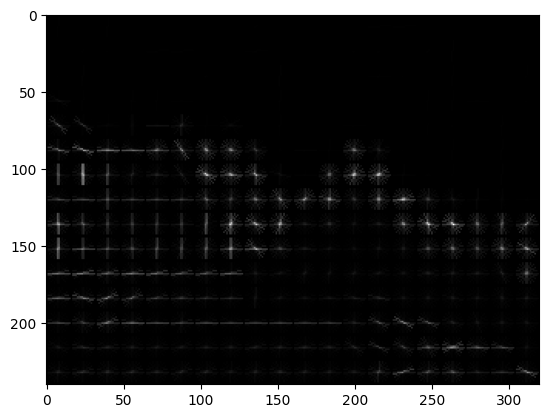

In [10]:
features,hog_img = hog(img_gray,
                       orientations = 11,
                       pixels_per_cell = (16,16),
                       cells_per_block = (2,2),
                       transform_sqrt = False,
                       visualize = True,
                       feature_vector = True)

plt.imshow(hog_img,cmap = 'gray')

In [11]:
pedestrian_hog_accum = []

# Extract HOG features for pedestrian images
for i in pedestrian:
    img_color = mpimg.imread(i)
    
    # Resize the image to a fixed size (e.g., (64, 64))
    img_color = cv2.resize(img_color, (64, 128))
    
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    pedestrian_hog_feature, pedestrian_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    pedestrian_hog_accum.append(pedestrian_hog_feature)

X_pedestrian = np.vstack(pedestrian_hog_accum).astype(np.float64)
y_pedestrian = np.ones(len(X_pedestrian))

In [12]:
non_pedestrian_hog_accum = []

# Extract HOG features for non-pedestrian images
for i in non_pedestrian:
    img_color = mpimg.imread(i)
    
    # Resize the image to a fixed size (e.g., (64, 64))
    img_color = cv2.resize(img_color, (64, 128))
    
    img_gray = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
    
    non_pedestrian_hog_feature, non_pedestrian_hog_img = hog(img_gray,
                                               orientations = 11,
                                               pixels_per_cell = (16,16),
                                               cells_per_block = (2,2),
                                               transform_sqrt = False,
                                               visualize = True,
                                               feature_vector = True)
    
    non_pedestrian_hog_accum.append(non_pedestrian_hog_feature)

X_non_pedestrian = np.vstack(non_pedestrian_hog_accum).astype(np.float64)
y_non_pedestrian = np.zeros(len(X_non_pedestrian))

In [13]:
# Combine pedestrian and non-pedestrian data
X = np.vstack((X_pedestrian,X_non_pedestrian))
y = np.hstack((y_pedestrian,y_non_pedestrian))

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [15]:
from sklearn.svm import SVC

svc_model = SVC()
svc_model.fit(X_train,y_train)
y_predict = svc_model.predict(X_test)

              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87       274
         1.0       0.83      0.76      0.79       184

    accuracy                           0.84       458
   macro avg       0.84      0.82      0.83       458
weighted avg       0.84      0.84      0.84       458



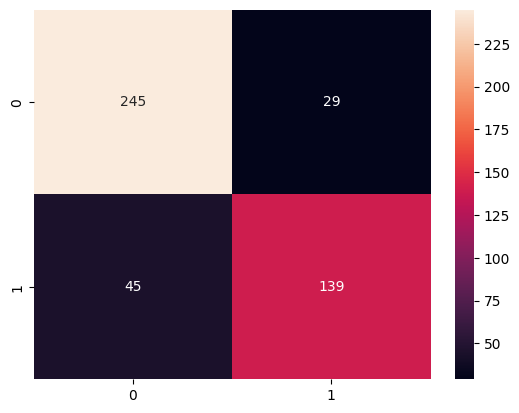

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

cm = confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt = "d")
print(classification_report(y_test,y_predict))

# GridSearchCV

In [25]:
param_grid = {'C': [0.1,1, 10, 100, 1000], 'gamma': [1,0.1,0.01,0.001,0.0001], 'kernel': ['rbf']} 

In [26]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']})

In [27]:
grid.best_params_

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [28]:
grid_predictions = grid.predict(X_test)

<Axes: >

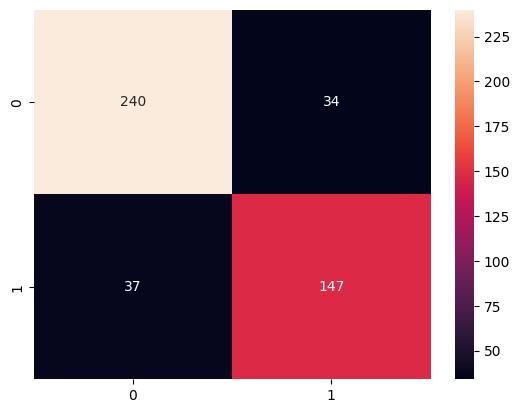

In [29]:
cm = confusion_matrix(y_test,grid_predictions)
sns.heatmap(cm, annot=True, fmt = "d")

## Modificaciones sobre código original para la detección de peatones
Las principales modificaciones realizadas en el código para adaptarlo a la detección de peatones fueron al procesamiento del conjunto de datos seleccionado, el cual corresponde a INRIA Person disponible en https://github.com/vinay0410/Pedestrian_Detection.

Este conjunto de datos consiste en imágenes etiquetadas como "positivas" que contienen personas, las cuales se utilizan para entrenar modelos de detección de peatones. También incluye imágenes de calles, paisajes y otras fotografías sin presencia de personas ni objetos similares a personas, las cuales se etiquetan como "negativas".

In [31]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

class PedestrianDetector:
    def __init__(self, model):
        self.model = model

    def process_frame(self, img):
        # Define parameters for sliding window
        window_size = (64, 128)  # Size of the sliding window
        step_size = 128  # Step size of the sliding window

        # Calculate the starting y-coordinate for the sliding window
        start_y = img.shape[0] // 2
        end_y = int(img.shape[0] * 0.75)

        # Slide the window over the image
        for y in range(start_y, end_y, step_size):
            for x in range(0, img.shape[1], step_size):
                # Extract the region of interest
                roi = img[y:y + window_size[1], x:x + window_size[0]]
                
                # Skip if the region of interest is not the same size as the window
                if roi.shape[0] != window_size[1] or roi.shape[1] != window_size[0]:
                    continue
                
                # Convert the region of interest to grayscale
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                
                # Compute HOG features for the region of interest
                roi_hog_feature, _ = hog(roi_gray,
                                        orientations=11,
                                        pixels_per_cell=(16, 16),
                                        cells_per_block=(2, 2),
                                        transform_sqrt=False,
                                        visualize=True,
                                        feature_vector=True)
                
                # Predict whether the region of interest contains a pedestrian
                y_pred = self.model.predict(roi_hog_feature.reshape(1, -1))
                
                # If a pedestrian is detected, draw a rectangle around the region of interest
                if y_pred == 1:
                    cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
        
        return img


    def process_video(self, input_video_path, output_video_path):
        cap = cv2.VideoCapture(input_video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the number of frames to process (25% of total frames)
        num_frames_to_process = int(total_frames * 0.5)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        pbar = tqdm(total=num_frames_to_process, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                result_frame = self.process_frame(frame)
                out.write(result_frame)
                cv2.imshow('Processed Frame', result_frame)

                pbar.update(1)
                frame_count += 1

                if frame_count >= num_frames_to_process:
                    break

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break

        pbar.close()

        cap.release()
        out.release()
        cv2.destroyAllWindows()

input_video_path = 'video_2_2.mp4'
output_video_path = 'output_video_2_1.mp4'
pedestrian_detector = PedestrianDetector(svc_model)
#pedestrian_detector.process_video(input_video_path, output_video_path)


In [32]:
input_video_path = 'video_2_2.mp4'
output_video_path = 'output_video_2_1_grid.mp4'
pedestrian_detector = PedestrianDetector(grid)
pedestrian_detector.process_video(input_video_path, output_video_path)

100%|████████████████████████████████████████████████████████████████| 1834/1834


In [22]:
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from skimage.feature import hog
import torch.nn.functional as F

# Set device
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
device

# Define the model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(924,462)
        self.fc2 = nn.Linear(462,231)
        self.fc3 = nn.Linear(231,115)
        self.fc4 = nn.Linear(115,10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.log_softmax(self.fc4(x), dim=1)

        return x

# Define the dataset class
class HOGDataset(Dataset):
    def __init__(self, X, y):
        self.features = torch.from_numpy(X).float()
        self.labels = torch.from_numpy(y).long()

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

# Convert HOG features to PyTorch tensors
X = np.vstack((X_pedestrian, X_non_pedestrian))
y = np.hstack((y_pedestrian, y_non_pedestrian))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the data into training and testing sets
train_dataset = HOGDataset(X_train, y_train)
test_dataset = HOGDataset(X_test, y_test)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(test_dataset, batch_size=batch_size)

model = Classifier()

model = model.to(device)
print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())



Classifier(
  (fc1): Linear(in_features=924, out_features=462, bias=True)
  (fc2): Linear(in_features=462, out_features=231, bias=True)
  (fc3): Linear(in_features=231, out_features=115, bias=True)
  (fc4): Linear(in_features=115, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [23]:
epochs = 100
steps = 0
print_every = 250
running_loss = 0

train_losses, validation_losses = [], []
model.to(device)

for epoch in range(epochs):
    for inputs, labels, in train_loader:
        steps += 1

        # Move inputs and label to the default device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero out the gradients of the optimizer
        optimizer.zero_grad()

        # Get the outputs of the model and compute loss 
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        # Compute the loss gradient using the backward method and have the optimizer take a step
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if steps % print_every == 0:
            validation_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validation_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    validation_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
          
            model.train()
            
            train_losses.append(running_loss/len(train_loader))
            validation_losses.append(validation_loss/len(validation_loader))

            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Validation Loss: {:.3f}.. ".format(validation_loss/len(validation_loader)),
              "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))
            
            running_loss = 0

Epoch: 15/100..  Training Loss: 7.770..  Validation Loss: 0.517..  Validation Accuracy: 0.763
Epoch: 30/100..  Training Loss: 4.023..  Validation Loss: 0.583..  Validation Accuracy: 0.761
Epoch: 45/100..  Training Loss: 2.629..  Validation Loss: 0.627..  Validation Accuracy: 0.796
Epoch: 59/100..  Training Loss: 1.418..  Validation Loss: 0.901..  Validation Accuracy: 0.800
Epoch: 74/100..  Training Loss: 1.043..  Validation Loss: 1.004..  Validation Accuracy: 0.807
Epoch: 89/100..  Training Loss: 0.724..  Validation Loss: 0.986..  Validation Accuracy: 0.800


In [24]:
import cv2
import numpy as np
from skimage.feature import hog
from tqdm import tqdm

class PedestrianDetector:
    def __init__(self, model):
        self.model = model

    def process_frame(self, img):
        # Define parameters for sliding window
        window_size = (64, 128)  # Size of the sliding window
        step_size = 128  # Step size of the sliding window

        # Calculate the starting y-coordinate for the sliding window
        start_y = img.shape[0] // 2
        end_y = int(img.shape[0] * 0.75)

        # Slide the window over the image
        for y in range(start_y, end_y, step_size):
            for x in range(0, img.shape[1], step_size):
                # Extract the region of interest
                roi = img[y:y + window_size[1], x:x + window_size[0]]
                
                # Skip if the region of interest is not the same size as the window
                if roi.shape[0] != window_size[1] or roi.shape[1] != window_size[0]:
                    continue
                
                # Convert the region of interest to grayscale
                roi_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
                
                # Compute HOG features for the region of interest
                roi_hog_feature = hog(roi_gray,
                                      orientations=11,
                                      pixels_per_cell=(16, 16),
                                      cells_per_block=(2, 2),
                                      transform_sqrt=False,
                                      visualize=False,
                                      feature_vector=True)
                
                # Convert the HOG feature to a PyTorch tensor
                roi_hog_feature = torch.from_numpy(roi_hog_feature).float().unsqueeze(0)
                
                # Move the tensor to the same device as the model
                roi_hog_feature = roi_hog_feature.to(next(self.model.parameters()).device)
                
                # Predict whether the region of interest contains a pedestrian
                with torch.no_grad():
                    outputs = self.model(roi_hog_feature)
                    _, predicted = torch.max(outputs.data, 1)
                
                # If a pedestrian is detected, draw a rectangle around the region of interest
                if predicted.item() == 1:
                    cv2.rectangle(img, (x, y), (x + window_size[0], y + window_size[1]), (0, 255, 0), 2)
        
        return img

    def process_video(self, input_video_path, output_video_path):
        cap = cv2.VideoCapture(input_video_path)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Calculate the number of frames to process (100% of total frames)
        num_frames_to_process = int(total_frames * 1)

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

        pbar = tqdm(total=num_frames_to_process, ncols=80, bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}')

        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if ret:
                result_frame = self.process_frame(frame)
                out.write(result_frame)
                cv2.imshow('Processed Frame', result_frame)

                pbar.update(1)
                frame_count += 1

                if frame_count >= num_frames_to_process:
                    break

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break

        pbar.close()

        cap.release()
        out.release()
        cv2.destroyAllWindows()

input_video_path = 'video_2_2.mp4'
output_video_path = 'output_video_2_2.mp4'
pedestrian_detector = PedestrianDetector(model)
pedestrian_detector.process_video(input_video_path, output_video_path)

100%|████████████████████████████████████████████████████████████████| 3669/3669
